<a id='sommaire'></a>
<h1 style='text-align:center;border:5px double;border-color:gray;'>
    <br/>
    PROJET 7<br/>
    <br/>
    "Effectuez une prédiction de revenus"
    <br/>
    <br/>
    Partie 2: Etude de modèles<br/>
</h1>

## [ANOVA de la variable revenus des enfants en fonction du pays](#anova)  
* [Préparation et représentation des données](#prepa)  
* [Vérification de l'hypothèse gaussienne](#verif)  

## [Régression linéaire du revenu enfant sur le revenu moyen du pays et l'indice de Gini](#reg1)  
* [Tests de significativité](#test1)  
* [Passage au logarithme du revenu enfant](#log1)  
* [Analyses de $R^2$](#rsq1)  
* [Analyse de l'atypicité sur les variables explicatives](#atyp1)  
* [Analyse de l'atypicité sur la variable à expliquer (residus studentisés)](#atyp1bis)  
* [Analyse de l'influence des observations](#infl1)  
* [Mesures atypiques et influentes](#atyp_infl1)  
* [Détection des problèmes de colinéarité](#vif1)  
* [Test d'homoscédasticité](#breu1)  
* [Test de normalité des résidus](#norm1)  


## [Régression linéaire du revenu enfant sur le revenu moyen du pays, l'indice de Gini et la classe de revenus des parents](#reg2)  
* [Tests de significativité](#test2)  
* [Passage au logarithme du revenu enfant](#log2)  
* [Analyses de $R^2$](#rsq2)  
* [Détection des problèmes de colinéarité](#vif2)  
* [Test d'homoscédasticité](#breu2)  
* [Test de normalité des résidus](#norm2)  
  

## [Conclusion](#ccl)  

In [1]:
#! coding:utf-8
import pandas as pd
print(pd.__version__)

0.23.4


In [2]:
import numpy as np
print(np.__version__)

1.15.4


In [3]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

print(matplotlib.__version__)

3.0.3


In [4]:
import seaborn as sns

print(sns.__version__)

0.9.0


In [5]:
import statsmodels

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

print(statsmodels.__version__)

0.9.0


In [6]:
import scipy

import scipy.stats as st
from scipy.stats import t, shapiro, ks_2samp

print(scipy.__version__)

1.1.0


In [7]:
from functions2 import *

In [8]:
import os
os.makedirs('graph', exist_ok=True)

### Mission: Créer un modèle permettant de déterminer le revenu potentiel d'une personne  
  

* Etude retrospective  
* Variable d'intérêt (dépendante, à expliquer): 'y_child' ou 'ln_y_child'  
* Facteur (variables indépendantes, explicatives): 'Pays', 'mj', 'ln_mj', 'Gj', 'c_i_parent'  
  
#### Description des variable:  
  
**y_child**: revenu  
**ln_y_child**: logarithme de y_child  
**Pays**: Pays d'appartenance d'un individus  
**mj**: revenu moyen par pays  
**ln_mj**: logarithme de mj  
**Gj**: Indice de Gini du pays  
**c_i_parent**: classe de revenu des parent

<a id='anova'></a>
## ANOVA de la variable revenus des enfants en fonction du pays

<a id='prepa'></a>
<h3 style='color:#8677b2'>Préparation et représentation des données</h3>

[Haut de page](#sommaire)

In [9]:
# Chargement des données
ready_db1 = pd.read_csv('analyse.csv')

ready_db1.head()

,Pays,y_child,Gj,pj,c_i_parent,mj,ln_y_child,ln_mj
0,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
1,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
2,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
3,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
4,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643


In [10]:
# Pour l'ensemble des tests, notre niveau de test sera:
alpha = 0.05

* Le pays d'origine a-t-il une influence sur le revenu?  

H0: Tous les pays ont le même revenu (tous les alpha_i sont nuls)  
Le pays n'a pas d'influence sur le revenu enfant moyen  
  
H1: Les revenus dépendent du pays (les alpha_i sont différents de 0)  
Le pays a une influence sur le revenu

In [11]:
# Agrégation pour gagner en temps de calculs
ready_db2 = ready_db1.groupby(by=['Pays',
                                  'y_child',
                                  'mj',
                                  'Gj',
                                  'pj',
                                  'ln_mj',
                                  'ln_y_child']).mean()
ready_db2.reset_index(inplace=True)
ready_db2.drop(columns=['c_i_parent'], inplace=True)

ready_db2.tail()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child
11595,Yemen,2568.6511,1042.63587,0.390259,0.916461,6.949507,7.851136
11596,Yemen,2893.9040,1042.63587,0.390259,0.916461,6.949507,7.970362
11597,Yemen,3307.2722,1042.63587,0.390259,0.916461,6.949507,8.103879
11598,Yemen,4137.0264,1042.63587,0.390259,0.916461,6.949507,8.327733
11599,Yemen,9050.4375,1042.63587,0.390259,0.916461,6.949507,9.110568


In [12]:
ready_db1.shape, ready_db2.shape

((5800000, 8), (11600, 7))

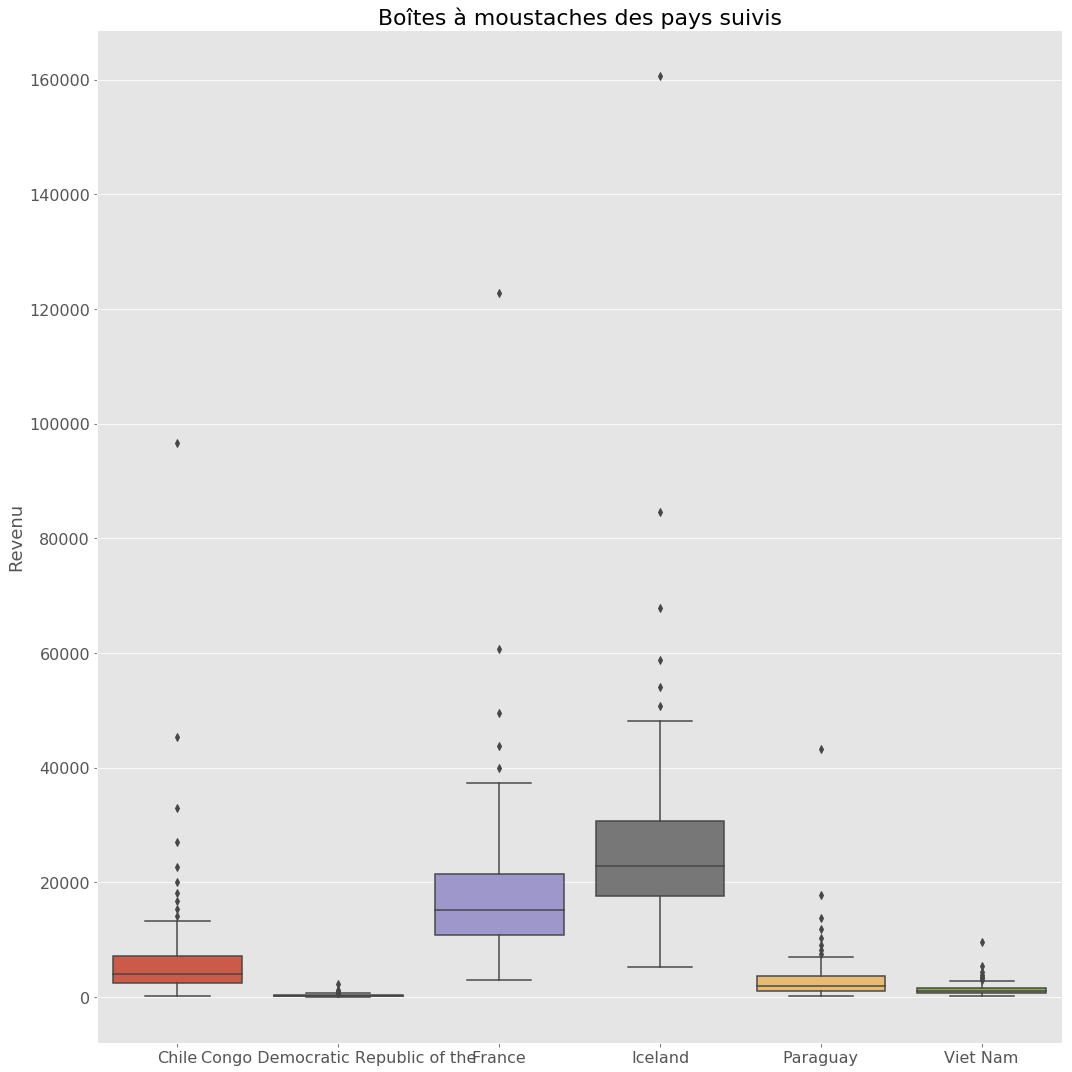

In [13]:
# Affichage des pays suivis
ready_db3 = ready_db2.loc[(ready_db2['Pays'] == 'France') | (ready_db2['Pays'] == 'Congo Democratic Republic of the') |
                          (ready_db2['Pays'] == 'Viet Nam') | (ready_db2['Pays'] == 'Chile') |
                          (ready_db2['Pays'] == 'Iceland') | (ready_db2['Pays'] == 'Paraguay')]

plt.figure(figsize=(15,15))

ax = sns.boxplot(x='Pays', y='y_child', data=ready_db3)

plt.ylabel('Revenu', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=16)
plt.title('Boîtes à moustaches des pays suivis', fontsize=22)

plt.tight_layout()

plt.savefig('graph/boxplot_annova.png')
plt.show()

In [14]:
# Réalisation de l'ANOVA
#Plan d'expérience complet et équilibré car  n_1 = ... = n_i = 100

anova_pays = smf.ols('y_child~Pays', data=ready_db2).fit(alpha=alpha)

anova_pays.summary().tables[0]

Dep. Variable:,y_child,R-squared:,0.496
Model:,OLS,Adj. R-squared:,0.491
Method:,Least Squares,F-statistic:,98.43
Date:,"Wed, 22 May 2019",Prob (F-statistic):,0.00
Time:,14:50:20,Log-Likelihood:,-1.1862e+05
No. Observations:,11600,AIC:,2.375e+05
Df Residuals:,11484,BIC:,2.383e+05
Df Model:,115,,
Covariance Type:,nonrobust,,


R<sup>2</sup> = 0.496  
R<sup>2</sup><sub>ajusté</sub> = 0.491  
La variable pays explique près de 50% de la variance du revenu  
Les autres facteurs non considérés dans le modèle expliquent l'autre moitié de la variance du revenu

In [15]:
# Affichage des resultats du test de Fisher  (influence de la variable pays)
test = sm.stats.anova_lm(anova_pays, typ=1)
test

,df,sum_sq,mean_sq,F,PR(>F)
Pays,115.0,5.102375e+11,4.436848e+09,98.429271,0.0
Residual,11484.0,5.176586e+11,4.507651e+07,NaN,NaN


H0: alpha_argentine = ... = alpha_yemen = 0 (Le pays n'a pas d'influence)  
H1: alpha_argentine = ... = alpha_yemen != 0 (Le pays a une influence)  
La p-valeur du Test de Fischer est: ~0.0  
p-valeur <<< 0.05  
On rejette donc l'hypothèse H0 et on conclut que le pays a une influence sur le revenu

In [16]:
#CME = SCE / (I - 1) variance expliquée
I = 116
SCE = test.iloc[0,1]
CME = SCE / (I - 1)
SCE, CME

(510237524303.9017, 4436848037.425232)

In [17]:
#CMR = SCR /  (I - n) variance inexpliquée
n = 11600
SCR = test.iloc[1,1]
CMR = SCR / (n - I)
SCR, CMR

(517658642063.21796, 45076510.106514975)

In [18]:
# F = CME / CMR
F = CME / CMR
F

98.42927118672321

In [19]:
# R_2 = SCE/ SCT = SCE / (SCE + SCR)
R_2 = SCE / (SCE + SCR)
R_2

0.49639014231099593

In [20]:
# R_2_ajusté = 1 - (n/(n - p)(1-R_2))
R_2_Aj = 1 - ((1 - R_2)*(n - 1)/(n - I -1))

R_2_Aj

0.4913027310515756

<a id='verif'></a>
<h3 style='color:#8677b2'>Vérification de l'hypothèse gaussienne</h3>

[Haut de page](#sommaire)

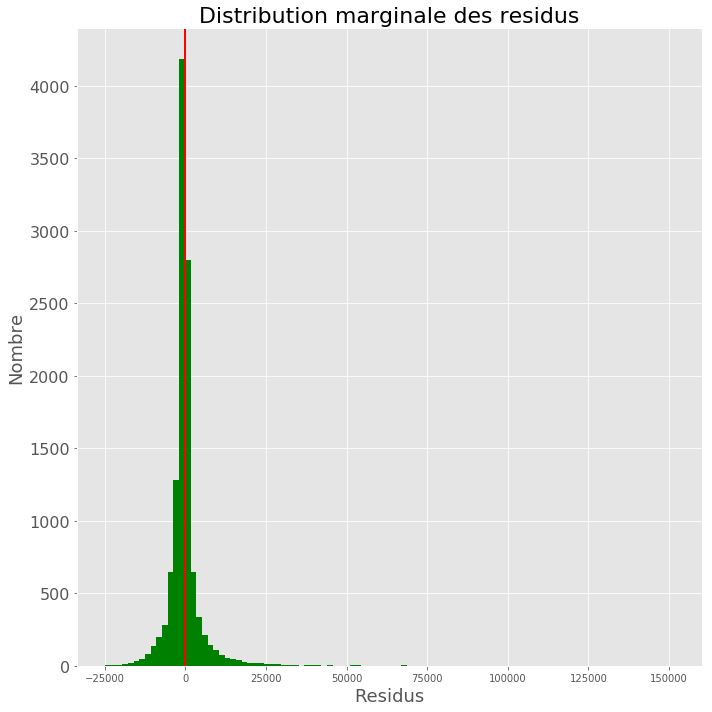

In [21]:
# Préparation des données
X = anova_pays.resid
Xbar = np.mean(X)
Xsprime = np.std(X)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X, 100, facecolor='g')
plt.axvline(Xbar, color='r', linewidth=2)

plt.title(f'Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

plt.savefig('graph/dist_marg_resid_anova.png')
plt.show()

In [22]:
# Test de normalité Shapiro-Wilk
shapiro(X)

/home/begalain/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.56099933385849, 0.0)

Le test Shapiro-Wilk n'est pas adapté à nos données, trop nombreuses

In [23]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(X,list(np.random.normal(Xbar, Xsprime, 11600)))

Ks_2sampResult(statistic=0.2442241379310346, pvalue=7.231728264173499e-302)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
p-value <<< 0.05, on rejette h0, y_child ne suit pas la loi normale(Xbar, XSprime)

In [24]:
# Test de Jarque-Bera
JB1, JBpv1, skw1, kurt1 = sm.stats.stattools.jarque_bera(X)
JB1, JBpv1, skw1, kurt1

(4207431.542160293, 0.0, 6.739339356074607, 95.32202335877405)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
JBpv ~ 0, on rejette H0, d'après le test, les données ne suivent pas une loi normale

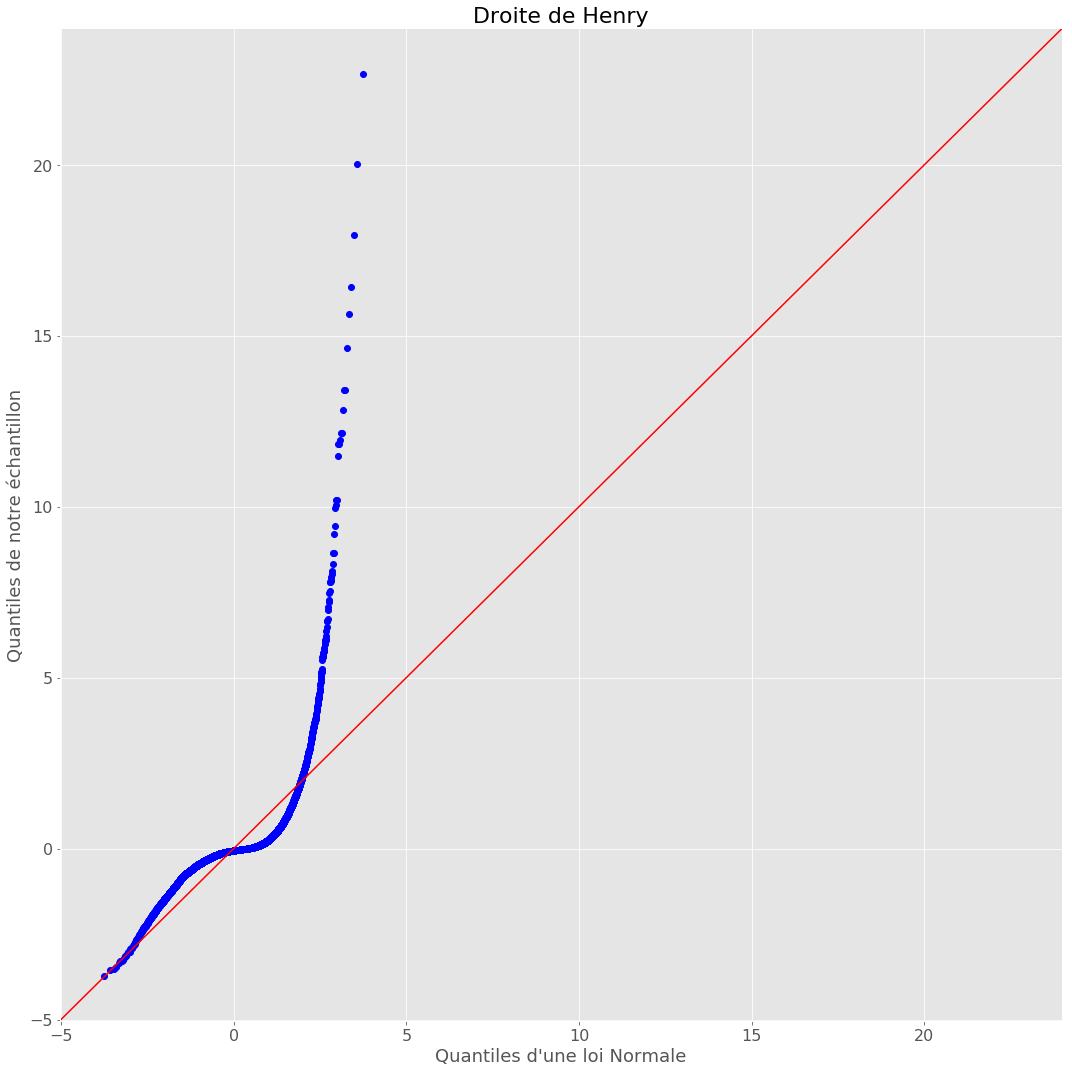

In [25]:
# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

plt.savefig('graph/droite_henry_anova.png')
plt.show()

<a id='reg1'></a>
## Régression linéaire du revenu enfant sur le revenu moyen du pays et l'indice de Gini

<a id='test1'></a>
<h3 style='color:#8677b2'>Tests de significativité</h3>

[Haut de page](#sommaire)

In [26]:
reg = smf.ols('y_child ~ Gj + mj', data=ready_db2)
reg_multi = reg.fit()
reg_multi.summary().tables[0]

Dep. Variable:,y_child,R-squared:,0.496
Model:,OLS,Adj. R-squared:,0.496
Method:,Least Squares,F-statistic:,5715.
Date:,"Wed, 22 May 2019",Prob (F-statistic):,0.00
Time:,14:50:21,Log-Likelihood:,-1.1862e+05
No. Observations:,11600,AIC:,2.372e+05
Df Residuals:,11597,BIC:,2.373e+05
Df Model:,2,,
Covariance Type:,nonrobust,,


**Test global:**  
H0: beta_GJ = beta_y_mj = 0  
H1: beta_GJ != beta_y_mj != 0  
F ~ 0.00 <<< alpha, on rejette H0, le modèle est globalement significatif

In [27]:
reg_multi.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.434e-10,328.716,-4.36e-13,1.000,-644.338,644.338
Gj,4.04e-10,749.825,5.39e-13,1.000,-1469.784,1469.784
mj,1.0000,0.010,99.934,0.000,0.980,1.020


 **Test de significativité des variables:**
   
H0: beta_Gj = 0  
H1: beta_Gj != 0  
Le paramètre beta_Gj de la variable Gj (indice de gini) n'est pas significatif au niveau de test alpha (0.05)  
En effet p-value ~ 1 > alpha, on accepte H0, le paramètre n'est pas significatif (beta_Gj = 0)  
  
H0: beta_y_mj = 0  
H1: beta_y_mj != 0  
Le paramètre beta_y_mj de la variable mj est significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_y_mj != 0)

<a id='log1'></a>
<h3 style='color:#8677b2'>Passage au logarithme du revenu enfant</h3>

[Haut de page](#sommaire)

In [28]:
reg_ln = smf.ols('ln_y_child ~ Gj + ln_mj', data=ready_db2)
reg_multi_ln = reg_ln.fit()

reg_multi_ln.summary().tables[0]

Dep. Variable:,ln_y_child,R-squared:,0.729
Model:,OLS,Adj. R-squared:,0.729
Method:,Least Squares,F-statistic:,1.558e+04
Date:,"Wed, 22 May 2019",Prob (F-statistic):,0.00
Time:,14:50:21,Log-Likelihood:,-12636.
No. Observations:,11600,AIC:,2.528e+04
Df Residuals:,11597,BIC:,2.530e+04
Df Model:,2,,
Covariance Type:,nonrobust,,


**Test global:**  
H0: beta_GJ = beta_ln_mj = 0  
H1: beta_GJ != beta_ln_mj != 0  
F ~ 0.00 <<< alpha, on rejette H0, le modèle est globalement significatif  

In [29]:
reg_multi_ln.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4961,0.065,7.646,0.000,0.369,0.623
Gj,-1.6523,0.078,-21.101,0.000,-1.806,-1.499
ln_mj,0.9864,0.006,163.259,0.000,0.975,0.998


 **Test de significativité:**
   
H0: beta_Gj = 0  
H1: beta_Gj != 0  
Le paramètre beta_Gj de la variable Gj (indice de gini) est significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_Gj != 0)  
  
H0: beta_ln_mj = 0  
H1: beta_ln_mj != 0  
Le paramètre beta_ln_mj de la variable ln_mj est significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_ln_mj != 0)

<a id='rsq1'></a>
<h3 style='color:#8677b2'>Analyses de $R^2$</h3>

[Haut de page](#sommaire)

In [30]:
# Anova sur les variables de notre régression linéaire
anova_ln = sm.stats.anova_lm(reg_multi_ln, typ=1)
anova_ln

,df,sum_sq,mean_sq,F,PR(>F)
Gj,1.0,2334.498202,2334.498202,4512.044930,0.0
ln_mj,1.0,13790.334757,13790.334757,26653.526637,0.0
Residual,11597.0,6000.200812,0.517392,NaN,NaN


In [31]:
# Calcul du R2 pour la variable 'Gj'
r2_Gj = anova_ln.sum_sq['Gj'] / anova_ln['sum_sq'].sum()
r2_Gj

0.10551388198747663

In [32]:
# Calcul du R2 pour la variable 'ln_y_child'
r2_ln_mj = anova_ln.sum_sq['ln_mj'] / anova_ln['sum_sq'].sum()
r2_ln_mj

0.6232910150247688

In [33]:
# Vérification
r2_Gj + r2_ln_mj, reg_multi_ln.rsquared

(0.7288048970122454, 0.7288048970122488)

In [34]:
print(f'Dans notre modèle:\n\n\
La variable \'Gj\' explique {100 * r2_Gj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
La variable \'ln_mj\' explique {100 * r2_ln_mj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
Notre modèle explique {100 * reg_multi_ln.rsquared:.2f}% de la variance de la variable \'ln_y_child\'')

Dans notre modèle:

La variable 'Gj' explique 10.55% de la variance de la variable 'ln_y_child'

La variable 'ln_mj' explique 62.33% de la variance de la variable 'ln_y_child'

Notre modèle explique 72.88% de la variance de la variable 'ln_y_child'


<a id='atyp1'></a>
<h3 style='color:#8677b2'>Analyse de l'atypicité sur les variables explicatives</h3>

[Haut de page](#sommaire)

In [35]:
# Paramètres de l'étude
n = ready_db2.shape[0]
p = 3

# Seuil levier selon Belsey
seuil_levier = 2 * p / n

In [36]:
# Ajout des termes diagonaux de H
ready_db2['levier'] = reg_multi_ln.get_influence().hat_matrix_diag

ready_db2.sort_values(by='levier', ascending=False).head()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier
9502,South Africa,192.2945,5617.90488,0.682949,0.677,8.633714,5.259028,0.001162
9528,South Africa,1022.7220,5617.90488,0.682949,0.677,8.633714,6.930223,0.001162
9530,South Africa,1099.0195,5617.90488,0.682949,0.677,8.633714,7.002174,0.001162
9531,South Africa,1133.6040,5617.90488,0.682949,0.677,8.633714,7.033157,0.001162
9532,South Africa,1175.4595,5617.90488,0.682949,0.677,8.633714,7.069414,0.001162


In [37]:
ready_db2.sort_values(by='levier').head()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier
9097,Romania,9831.8030,3318.337189,0.389527,0.369699,8.107219,9.193378,0.000087
9027,Romania,1746.9655,3318.337189,0.389527,0.369699,8.107219,7.465636,0.000087
9028,Romania,1794.1764,3318.337189,0.389527,0.369699,8.107219,7.492301,0.000087
9029,Romania,1845.0685,3318.337189,0.389527,0.369699,8.107219,7.520272,0.000087
9030,Romania,1890.7778,3318.337189,0.389527,0.369699,8.107219,7.544744,0.000087


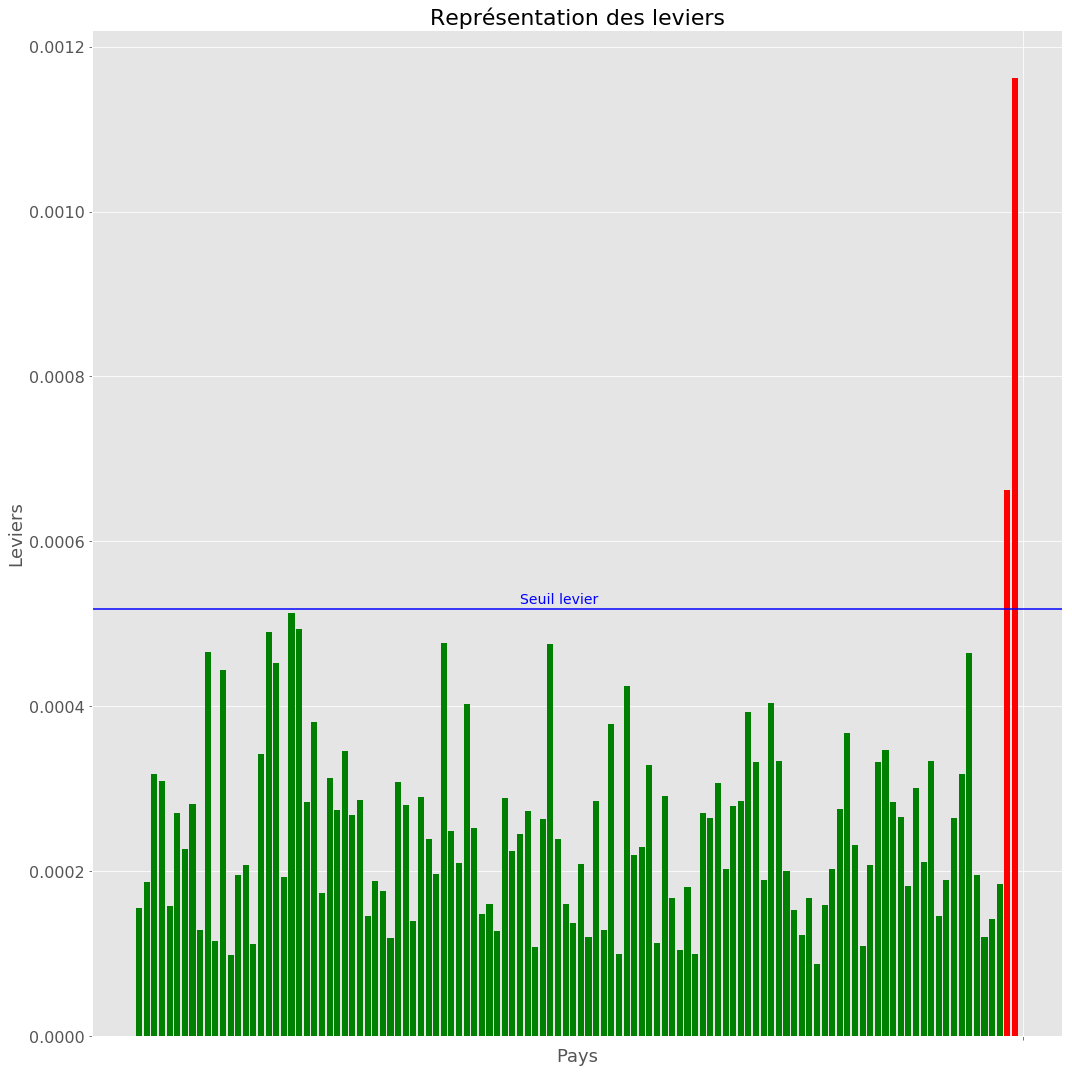

In [38]:
ready_db4 = ready_db2.groupby(['Pays', 'mj', 'Gj', 'pj', 'ln_mj']).mean()
ready_db4.reset_index(inplace=True)

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db4.loc[ready_db4['levier'] <= seuil_levier]['Pays'],
        ready_db4.loc[ready_db4['levier'] <= seuil_levier]['levier'], color='g')

# Individus au dessus du seuil
plt.bar(ready_db4.loc[ready_db4['levier'] > seuil_levier]['Pays'],
        ready_db4.loc[ready_db4['levier'] > seuil_levier]['levier'], color='r')

# Décoration et annotations
plt.title('Représentation des leviers', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.xticks('', fontsize=16)
plt.ylabel('Leviers', fontsize=18)
plt.yticks(fontsize=16)
plt.axhline(y=seuil_levier, color='b', linestyle='-')
plt.text(50, 0.000525 , 'Seuil levier', fontsize = '14', color='b')
plt.tight_layout()

plt.savefig('graph/leviers1.png')
plt.show()

In [39]:
# Nombre de valeurs atypiques sur les variables explicatives
lev_ln = ready_db2.loc[ready_db2['levier'] > seuil_levier, :]
len(lev_ln)

200

In [40]:
# Pays presentants des valeurs atypiques
ready_db4.loc[ready_db4['levier'] > seuil_levier]

,Pays,mj,Gj,pj,ln_mj,y_child,ln_y_child,levier
42,Honduras,3296.268419,0.615512,0.940737,8.100546,3296.268419,7.380957,0.000662
95,South Africa,5617.904880,0.682949,0.677000,8.633714,5617.904880,7.717752,0.001162


In [41]:
ready_db4.sort_values(by='levier', ascending=False).head()

,Pays,mj,Gj,pj,ln_mj,y_child,ln_y_child,levier
95,South Africa,5617.904880,0.682949,0.677000,8.633714,5617.904880,7.717752,0.001162
42,Honduras,3296.268419,0.615512,0.940737,8.100546,3296.268419,7.380957,0.000662
20,Colombia,3547.005275,0.583437,1.095440,8.173859,3547.005276,7.556374,0.000513
21,Congo Democratic Republic of the,276.016044,0.459403,0.707703,5.620459,276.016044,5.288002,0.000494
17,Central African Republic,811.299901,0.575972,0.661654,6.698638,811.299901,6.130762,0.000490


<a id='atyp1bis'></a>
<h3 style='color:#8677b2'>Analyse de l'atypicité sur la variable à expliquer (residus studentisés)</h3>

[Haut de page](#sommaire)

In [42]:
# Détermination du seuil statistique d'atypicité
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
seuil_rstudent

1.9601685822161563

In [43]:
# statistique de test par observation
ready_db2['rstudent'] = reg_multi_ln.get_influence().resid_studentized_internal
ready_db2.sort_values(by='rstudent').head()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier,rstudent
5600,Korea Republic of,17.317732,15227.569445,0.367935,0.394000,9.630863,2.851731,0.000238,-9.087780
1600,Canada,122.424810,23739.640518,0.366553,0.269333,10.074902,4.807497,0.000341,-6.980981
1900,China,16.719418,2522.758726,0.493332,0.399000,7.833108,2.816571,0.000193,-6.382910
900,Bolivia,20.584948,3016.263843,0.575719,0.866268,8.011774,3.024560,0.000465,-6.150327
5000,Israel,142.350430,11100.318137,0.429918,0.348050,9.314729,4.958292,0.000224,-5.582806


In [44]:
ready_db2.sort_values(by='rstudent').tail()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier,rstudent
999,Bolivia,43786.920,3016.263843,0.575719,0.866268,8.011774,10.687090,0.000465,4.504913
1799,Central African Republic,14472.948,811.299901,0.575972,0.661654,6.698638,9.580037,0.000490,4.767232
9599,South Africa,82408.550,5617.904880,0.682949,0.677000,8.633714,11.319444,0.001162,4.779222
4299,Honduras,56265.700,3296.268419,0.615512,0.940737,8.100546,10.937840,0.000662,4.823737
4099,Guatemala,39799.406,2142.474753,0.582468,1.015206,7.669717,10.591607,0.000476,4.856839


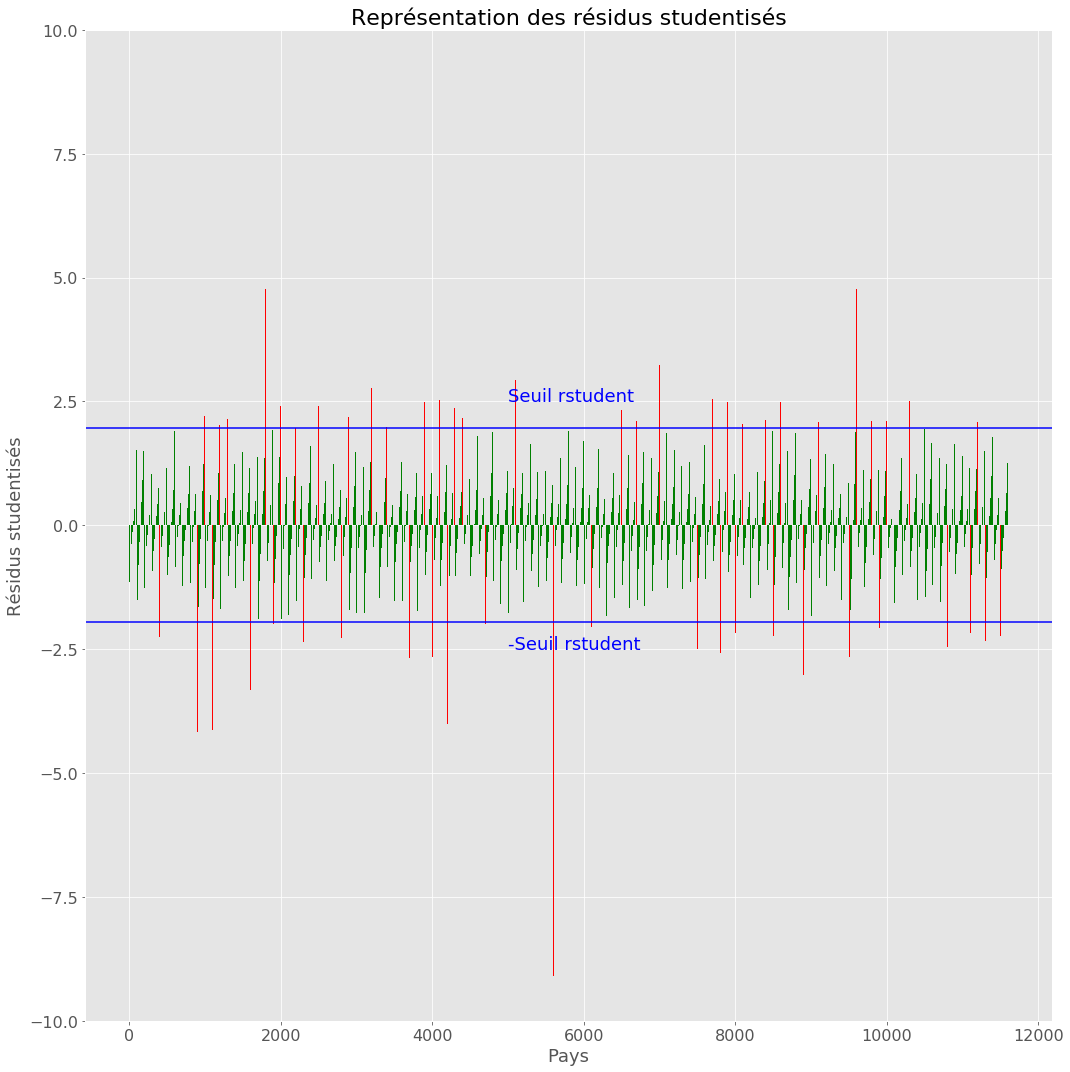

In [45]:
ready_db5 = ready_db2.groupby(['Pays', 'mj', 'Gj', 'pj', 'ln_mj', 'rstudent']).mean()
ready_db5.reset_index(inplace=True)

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db5.loc[(ready_db5['rstudent'] <= seuil_rstudent) & (ready_db5['rstudent'] >= -seuil_rstudent)].index,
        ready_db5.loc[(ready_db5['rstudent'] <= seuil_rstudent) & (ready_db5['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db5.loc[ready_db5['rstudent'] > seuil_rstudent].index,
        ready_db5.loc[ready_db5['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db5.loc[ready_db5['rstudent'] < -seuil_rstudent].index,
        ready_db5.loc[ready_db5['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.ylabel('Résidus studentisés', fontsize=18)
plt.yticks(fontsize=16)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(5_000, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(5_000, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graph/res_stu.png', dpi=300)
plt.show()

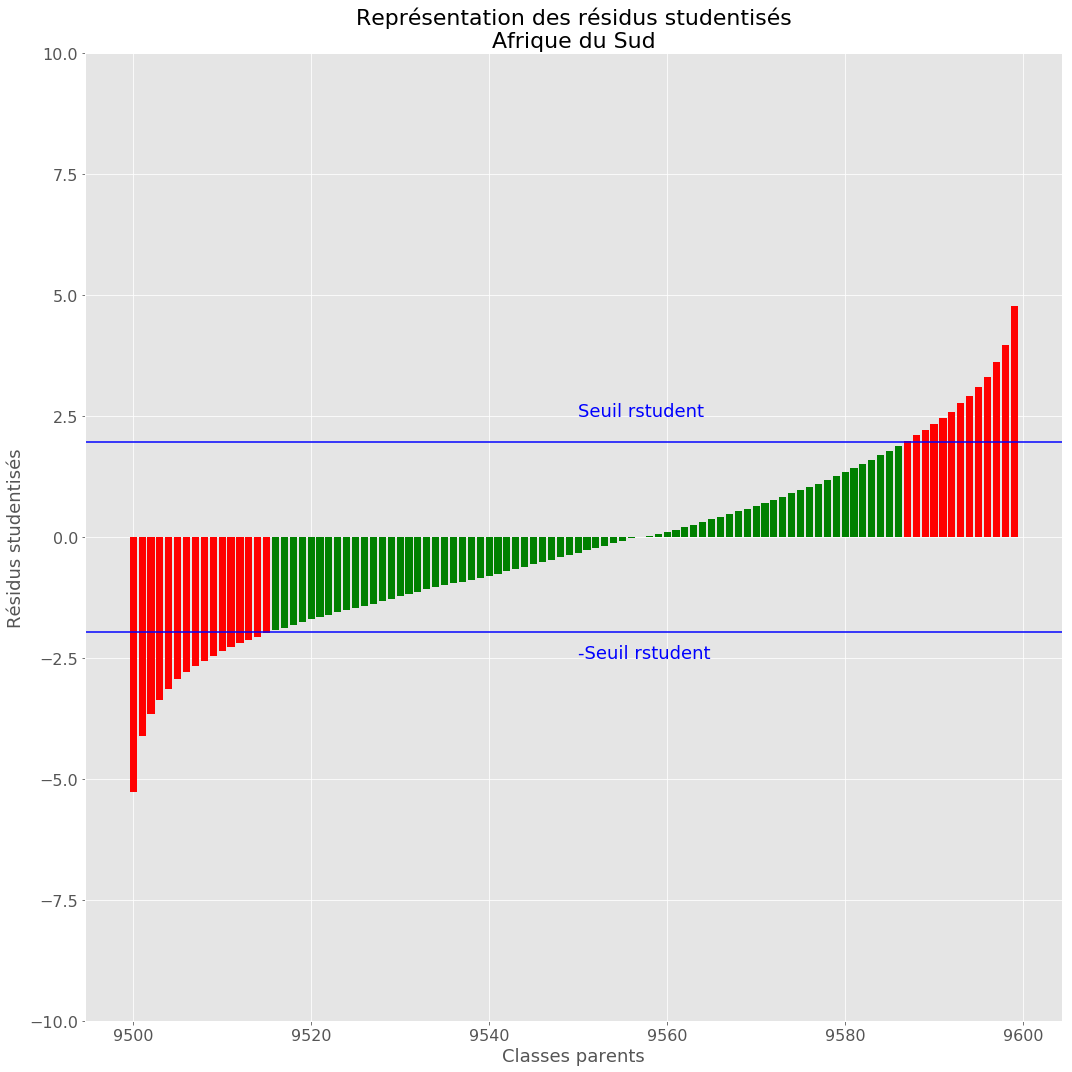

In [46]:
ready_db_saf = ready_db5.loc[(ready_db5['Pays'] == 'South Africa')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db_saf.loc[(ready_db_saf['rstudent'] <= seuil_rstudent) & (ready_db_saf['rstudent'] >= -seuil_rstudent)].index,
        ready_db_saf.loc[(ready_db_saf['rstudent'] <= seuil_rstudent) & (ready_db_saf['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db_saf.loc[ready_db_saf['rstudent'] > seuil_rstudent].index,
        ready_db_saf.loc[ready_db_saf['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db_saf.loc[ready_db_saf['rstudent'] < -seuil_rstudent].index,
        ready_db_saf.loc[ready_db_saf['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\nAfrique du Sud', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(9550, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(9550, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graph/res_saf.png')
plt.show()

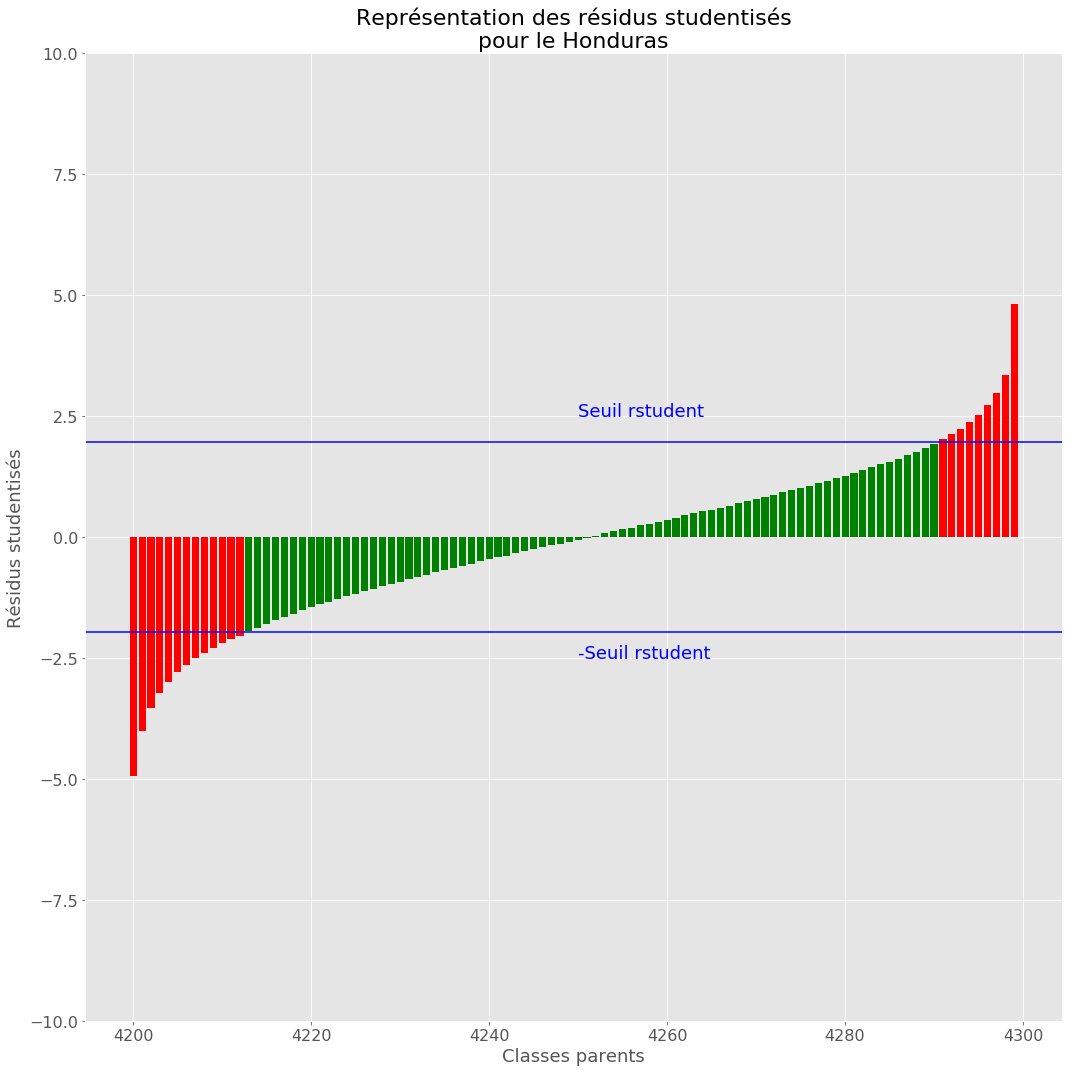

In [47]:
ready_db_hon = ready_db5.loc[(ready_db5['Pays'] == 'Honduras')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db_hon.loc[(ready_db_hon['rstudent'] <= seuil_rstudent) & (ready_db_hon['rstudent'] >= -seuil_rstudent)].index,
        ready_db_hon.loc[(ready_db_hon['rstudent'] <= seuil_rstudent) & (ready_db_hon['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db_hon.loc[ready_db_hon['rstudent'] > seuil_rstudent].index,
        ready_db_hon.loc[ready_db_hon['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db_hon.loc[ready_db_hon['rstudent'] < -seuil_rstudent].index,
        ready_db_hon.loc[ready_db_hon['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\npour le Honduras', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(4250, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(4250, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graph/res_hon.png')
plt.show()

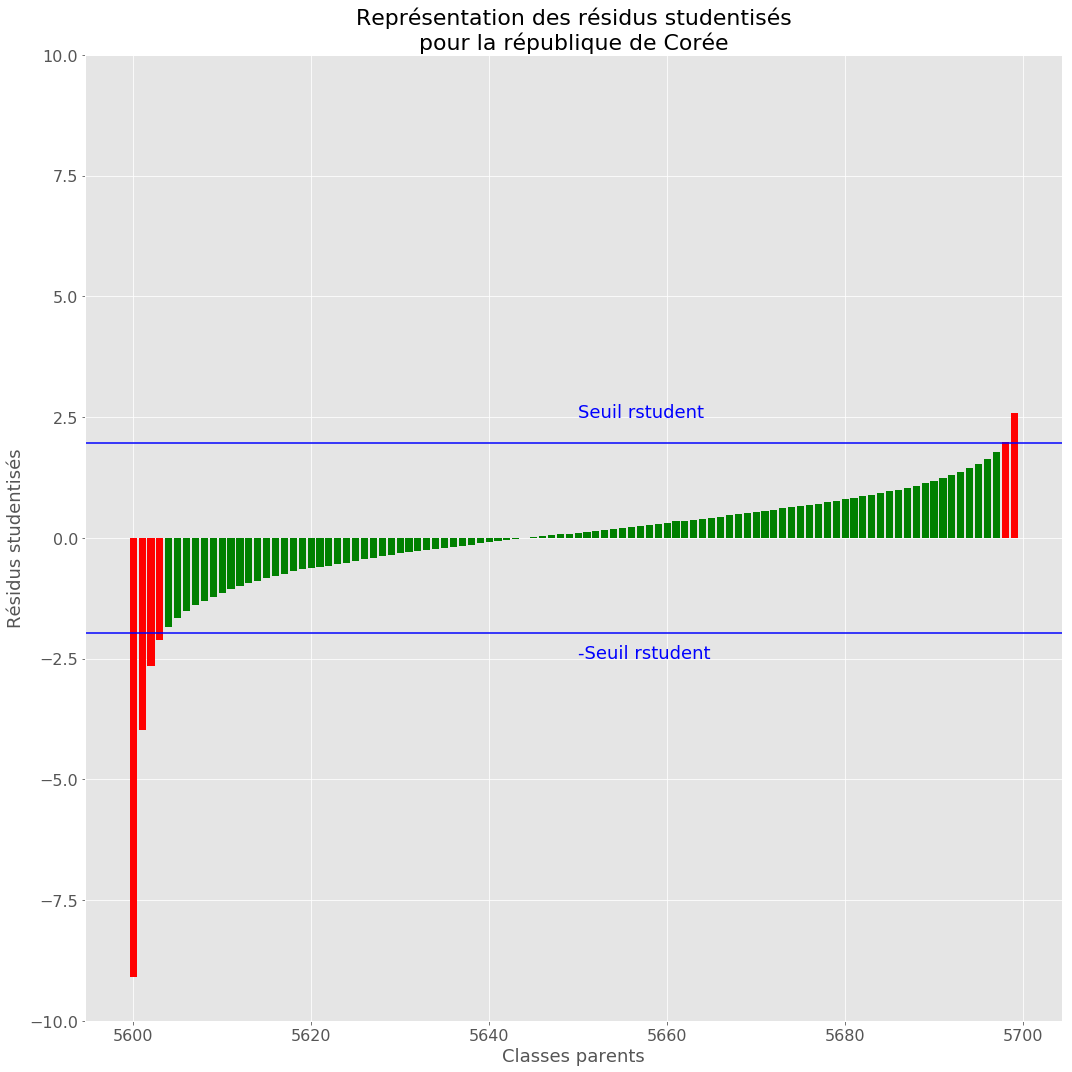

In [48]:
ready_db_kor = ready_db5.loc[(ready_db5['Pays'] == 'Korea Republic of')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db_kor.loc[(ready_db_kor['rstudent'] <= seuil_rstudent) & (ready_db_kor['rstudent'] >= -seuil_rstudent)].index,
        ready_db_kor.loc[(ready_db_kor['rstudent'] <= seuil_rstudent) & (ready_db_kor['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db_kor.loc[ready_db_kor['rstudent'] > seuil_rstudent].index,
        ready_db_kor.loc[ready_db_kor['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db_kor.loc[ready_db_kor['rstudent'] < -seuil_rstudent].index,
        ready_db_kor.loc[ready_db_kor['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\npour la république de Corée', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(5650, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(5650, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graph/res_kor.png')
plt.show()

In [49]:
# Nombre de valeurs atypiques sur les variables à expliquer
res_stu_ln = ready_db5.loc[(ready_db5['rstudent'] > seuil_rstudent) |
                             (ready_db5['rstudent'] < -seuil_rstudent)]

len(res_stu_ln)

640

In [50]:
# Pays presentants des valeurs atypiques
ready_db5.loc[ready_db5.index.isin(res_stu_ln.index)].groupby(by='Pays').count().sort_values(by='y_child',
                                                                                             ascending=False)

,mj,Gj,pj,ln_mj,rstudent,y_child,ln_y_child,levier
Pays,,,,,,,,
South Africa,29,29,29,29,29,29,29,29
Honduras,22,22,22,22,22,22,22,22
Bolivia,20,20,20,20,20,20,20,20
Colombia,17,17,17,17,17,17,17,17
Panama,16,16,16,16,16,16,16,16
Brazil,16,16,16,16,16,16,16,16
Mexico,14,14,14,14,14,14,14,14
Guatemala,14,14,14,14,14,14,14,14
Central African Republic,14,14,14,14,14,14,14,14


<a id='infl1'></a>
<h3 style='color:#8677b2'>Analyse de l'influence des observations</h3>

[Haut de page](#sommaire)

In [51]:
# Création du dataframe avec tous les resultats d'influences disponibles
influence_ln = reg_multi_ln.get_influence().summary_frame()
influence_ln.head()

,dfb_Intercept,dfb_Gj,dfb_ln_mj,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.012627,0.014549,0.005306,0.000161,-1.764461,0.000155,-0.021960,-1.764622,-0.021962
1,-0.010346,0.011921,0.004348,0.000108,-1.445786,0.000155,-0.017994,-1.445854,-0.017995
2,-0.009372,0.010799,0.003938,0.000089,-1.309708,0.000155,-0.016300,-1.309749,-0.016301
3,-0.008651,0.009968,0.003635,0.000075,-1.208936,0.000155,-0.015046,-1.208960,-0.015046
4,-0.008240,0.009495,0.003463,0.000068,-1.151560,0.000155,-0.014332,-1.151576,-0.014332


In [52]:
# Ajout de la colonne distance de Cook à notre dataframe analyses_ln
ready_db2['dcooks'] = influence_ln['cooks_d']

# Seuil d'influence selon Cook
seuil_dcook = 4/(n-p)

ready_db2.sort_values(by='dcooks').head()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier,rstudent,dcooks
9951,Swaziland,362.52875,530.283828,0.478735,0.629976,6.273412,5.893104,0.000332,0.000087,8.446875e-13
1352,Burkina Faso,693.67725,917.952658,0.413469,0.661654,6.822146,6.542007,0.000195,-0.000172,1.922609e-12
10251,Taiwan Republic of China,13724.78200,16500.223670,0.331487,0.181000,9.711129,9.526958,0.000266,-0.000317,8.879644e-12
6853,Mali,576.89970,681.075039,0.346782,0.713953,6.523672,6.357668,0.000328,-0.000336,1.234295e-11
2654,Czech Republic,7657.33450,8235.293411,0.270162,0.434041,9.016184,8.943419,0.000274,0.000528,2.549086e-11


In [53]:
ready_db2.sort_values(by='dcooks').tail()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier,rstudent,dcooks
9598,South Africa,46297.316000,5617.904880,0.682949,0.677,8.633714,10.742839,0.001162,3.977135,0.006135
9501,South Africa,138.341550,5617.904880,0.682949,0.677,8.633714,4.929726,0.001162,-4.109191,0.006549
5600,Korea Republic of,17.317732,15227.569445,0.367935,0.394,9.630863,2.851731,0.000238,-9.087780,0.006565
9599,South Africa,82408.550000,5617.904880,0.682949,0.677,8.633714,11.319444,0.001162,4.779222,0.008859
9500,South Africa,60.490383,5617.904880,0.682949,0.677,8.633714,4.102484,0.001162,-5.259924,0.010731


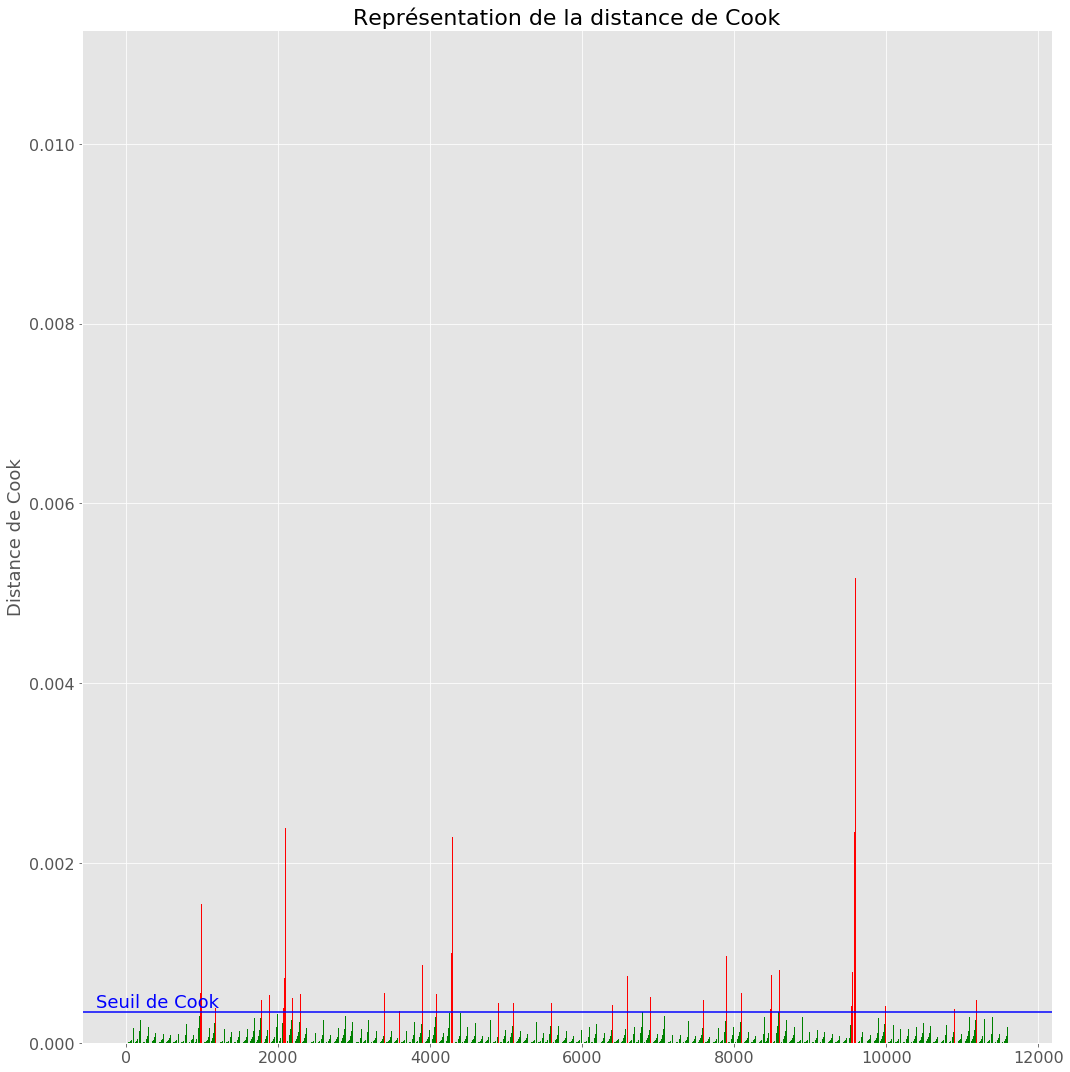

In [54]:
ready_db6 = ready_db2.groupby(['Pays', 'mj', 'Gj', 'pj', 'ln_mj', 'dcooks']).mean()
ready_db6.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db6.loc[ready_db6['dcooks'] <= seuil_dcook].index,
        ready_db6.loc[ready_db6['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(ready_db6.loc[ready_db6['dcooks'] > seuil_dcook].index,
        ready_db6.loc[ready_db6['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(-400, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graph/dist_cook.png')
plt.show()

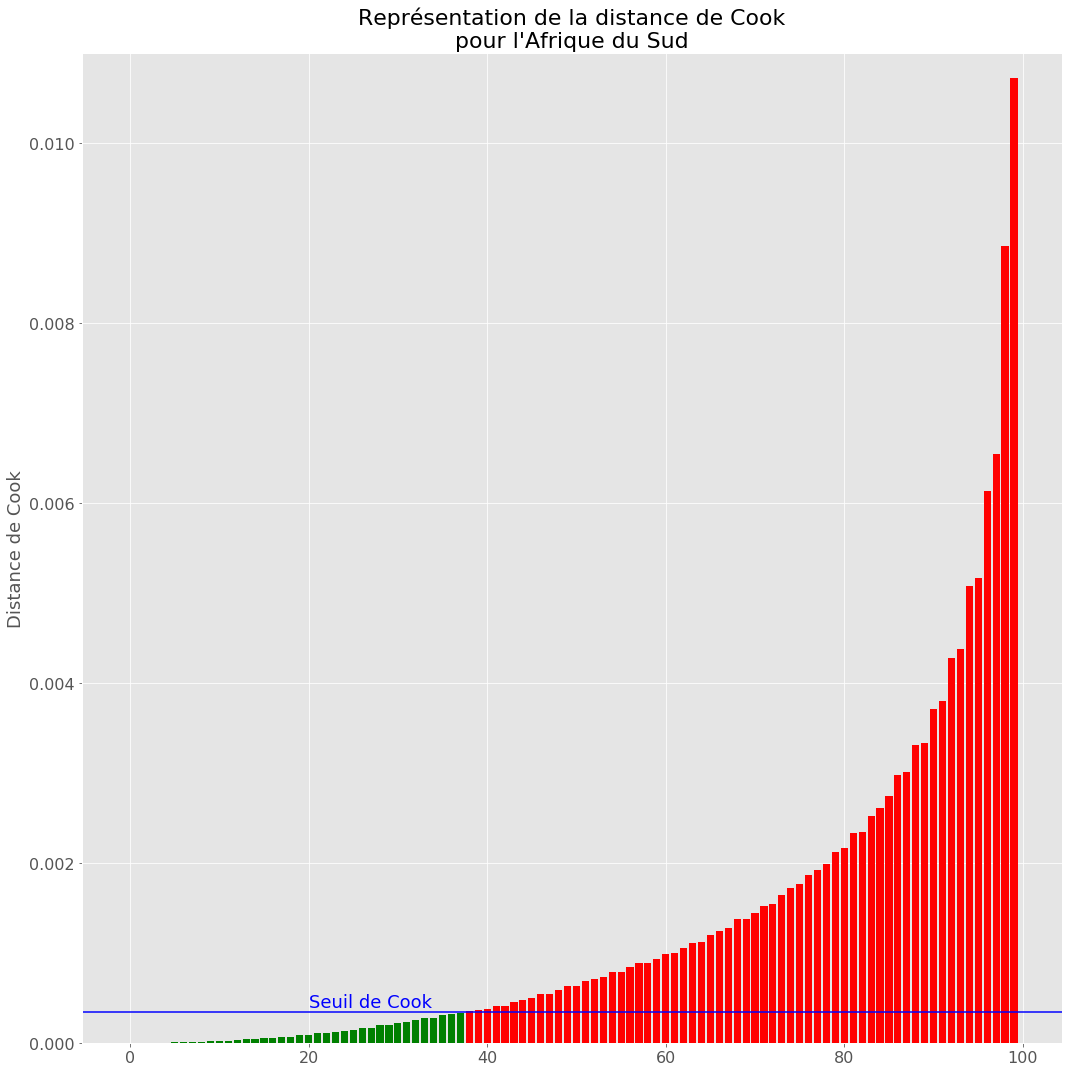

In [55]:
ready_db_saf1 = ready_db6.loc[ready_db6['Pays'] == 'South Africa']
ready_db_saf1.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db_saf1.loc[ready_db_saf1['dcooks'] <= seuil_dcook].index,
        ready_db_saf1.loc[ready_db_saf1['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(ready_db_saf1.loc[ready_db_saf1['dcooks'] > seuil_dcook].index,
        ready_db_saf1.loc[ready_db_saf1['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook\npour l\'Afrique du Sud', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.ylim(0,0.011)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(20, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graph/dist_cook_saf.png')
plt.show()

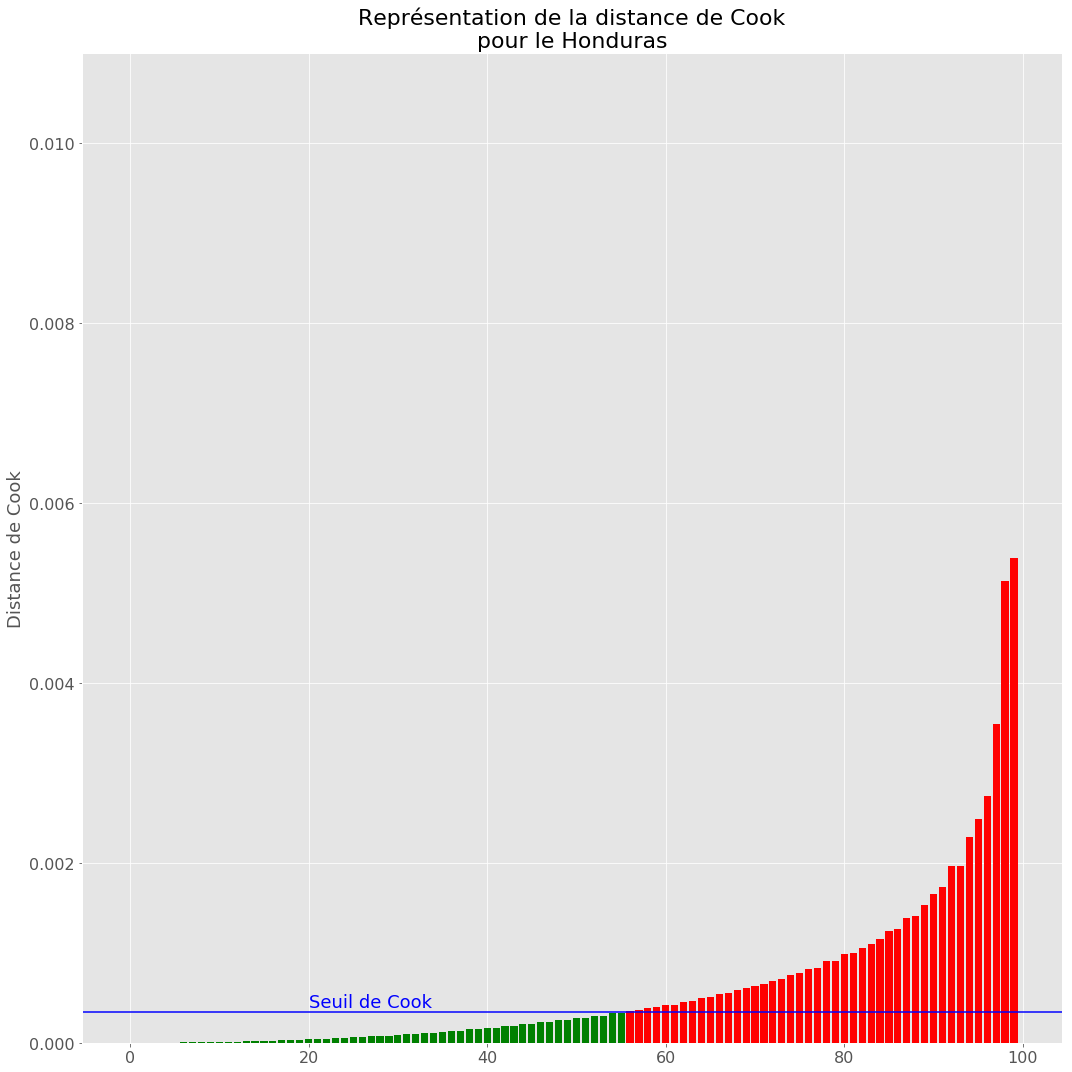

In [56]:
ready_db_hon1 = ready_db6.loc[ready_db6['Pays'] == 'Honduras']
ready_db_hon1.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db_hon1.loc[ready_db_hon1['dcooks'] <= seuil_dcook].index,
        ready_db_hon1.loc[ready_db_hon1['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(ready_db_hon1.loc[ready_db_hon1['dcooks'] > seuil_dcook].index,
        ready_db_hon1.loc[ready_db_hon1['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook\npour le Honduras', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.ylim(0,0.011)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(20, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graph/dist_cook_hon.png')
plt.show()

In [57]:
# Nombre d'observations influentes
dco_ln = ready_db2.loc[ready_db2['dcooks'] > seuil_dcook]
len(dco_ln)

657

In [58]:
# Pays présentants des obervations au dela du seuil
ready_db6.loc[ready_db6.index.isin(dco_ln.index)].groupby(by='Pays').count().sort_values(by='y_child',
                                                                                         ascending=False)

,mj,Gj,pj,ln_mj,dcooks,y_child,ln_y_child,levier,rstudent
Pays,,,,,,,,,
South Africa,62,62,62,62,62,62,62,62,62
Honduras,44,44,44,44,44,44,44,44,44
Bolivia,31,31,31,31,31,31,31,31,31
Colombia,31,31,31,31,31,31,31,31,31
Central African Republic,26,26,26,26,26,26,26,26,26
Brazil,26,26,26,26,26,26,26,26,26
Guatemala,25,25,25,25,25,25,25,25,25
Panama,24,24,24,24,24,24,24,24,24
Chile,20,20,20,20,20,20,20,20,20


<a id='atyp_infl1'></a>
<h3 style='color:#8677b2'>Mesures atypiques et influentes</h3>

[Haut de page](#sommaire)

In [59]:
ready_db2.head()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier,rstudent,dcooks
0,Albania,728.89795,2994.829902,0.32141,0.815874,8.004643,6.591534,0.000155,-1.764461,0.000161
1,Albania,916.66235,2994.829902,0.32141,0.815874,8.004643,6.820739,0.000155,-1.445786,0.000108
2,Albania,1010.91600,2994.829902,0.32141,0.815874,8.004643,6.918612,0.000155,-1.309708,0.000089
3,Albania,1086.90780,2994.829902,0.32141,0.815874,8.004643,6.991092,0.000155,-1.208936,0.000075
4,Albania,1132.69970,2994.829902,0.32141,0.815874,8.004643,7.032359,0.000155,-1.151560,0.000068


In [60]:
# Obeservations atypiques et influentes
ind_aty_infl_ln = ready_db2.loc[((ready_db2['dcooks'] > seuil_dcook) &
                                  (ready_db2['rstudent'] > seuil_rstudent) &
                                  (ready_db2['levier'] > seuil_levier)) |
                                  ((ready_db2['dcooks'] > seuil_dcook) &
                                  (ready_db2['rstudent'] < -seuil_rstudent) &
                                  (ready_db2['levier'] > seuil_levier))]
len(ind_aty_infl_ln)

51

In [61]:
# Pays contenants les observations influentes et atypiques
susp_pt = ready_db2.loc[ready_db2.index.isin(ind_aty_infl_ln.index)]
susp_pt.reset_index(inplace=True)
susp_pt.groupby('Pays').count()

,index,y_child,mj,Gj,pj,ln_mj,ln_y_child,levier,rstudent,dcooks
Pays,,,,,,,,,,
Honduras,22,22,22,22,22,22,22,22,22,22
South Africa,29,29,29,29,29,29,29,29,29,29


<a id='vif1'></a>
<h3 style='color:#8677b2'>Détection des problèmes de colinéarité</h3>

[Haut de page](#sommaire)

In [62]:
# Facteur d'influence de la variance (Variance Inflation Factor)
mat_cor = np.corrcoef(ready_db2.ln_mj, ready_db2.Gj)
1 / (1-(mat_cor[0,1]**2)), mat_cor[0,1]

(1.0769055273597412, -0.26723293053163943)

In [63]:
# Inmpact du R2 sur le VIF
1 / (1 - 0.94**2), 1 / (1 - 0.95**2), 1 / (1 - 0.89**2), 1 / (1 - 0.90**2)

(8.591065292096216, 10.256410256410254, 4.810004810004811, 5.263157894736843)

* VIF_Gj et VIF_ln_y_child_moy < 10 (ou même 5)   
Pas de problème de colinéarité

<a id='breu1'></a>
<h3 style='color:#8677b2'>Test d'homoscédasticité</h3>

[Haut de page](#sommaire)

In [64]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_ln.resid, reg_multi_ln.model.exog)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.999264381321618e-154


H0: Homoscédasticité  
H1: Hétéroscédasticité  
pvalue <<< alpha, rejet de H0, il y a hétéroscédasticité des residus  
Encore une fois, le modèle de regression linéaire multiple est suffisamment robuste pour les grands échantillons. 11_660 ici, c'est notre cas.  
Plus on a de données à disposition, plus le modèle est capable de supporter des écarts important aux hypothèse (gaussienne et homoscédastique)

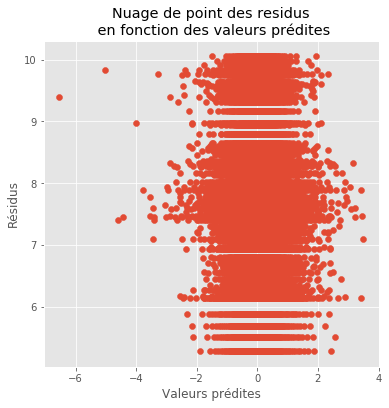

In [65]:
# Représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_ln.resid, reg_multi_ln.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

plt.savefig('graph/homoscedasticity.png')
plt.show()

<a id='norm1'></a>
<h3 style='color:#8677b2'>Test de normalité des résidus</h3>

[Haut de page](#sommaire)

In [66]:
# Préparation des données
X_ln = reg_multi_ln.resid
Xbar_ln = np.mean(X_ln)
Xsprime_ln = np.std(X_ln)

# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(reg_multi_ln.resid, list(np.random.normal(Xbar_ln, Xsprime_ln, 11_600)))

Ks_2sampResult(statistic=0.03948275862068973, pvalue=2.645886883409486e-08)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
p-value <<< 0.05, on rejette H0, y_child ne suit pas une loi normale

In [67]:
# Test de Jarque-Bera (test de normalité basé sur le kurtosis et le skewness)
JB_ln, JBpv_ln, skw_ln, kurt_ln = sm.stats.stattools.jarque_bera(reg_multi_ln.resid)
JB_ln, JBpv_ln, skw_ln, kurt_ln

(3504.7610988912247, 0.0, -0.0808763837215548, 5.687948269963439)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
JBpv ~ 0, on rejette H0, d'après le test, les données ne suivent pas une loi normale

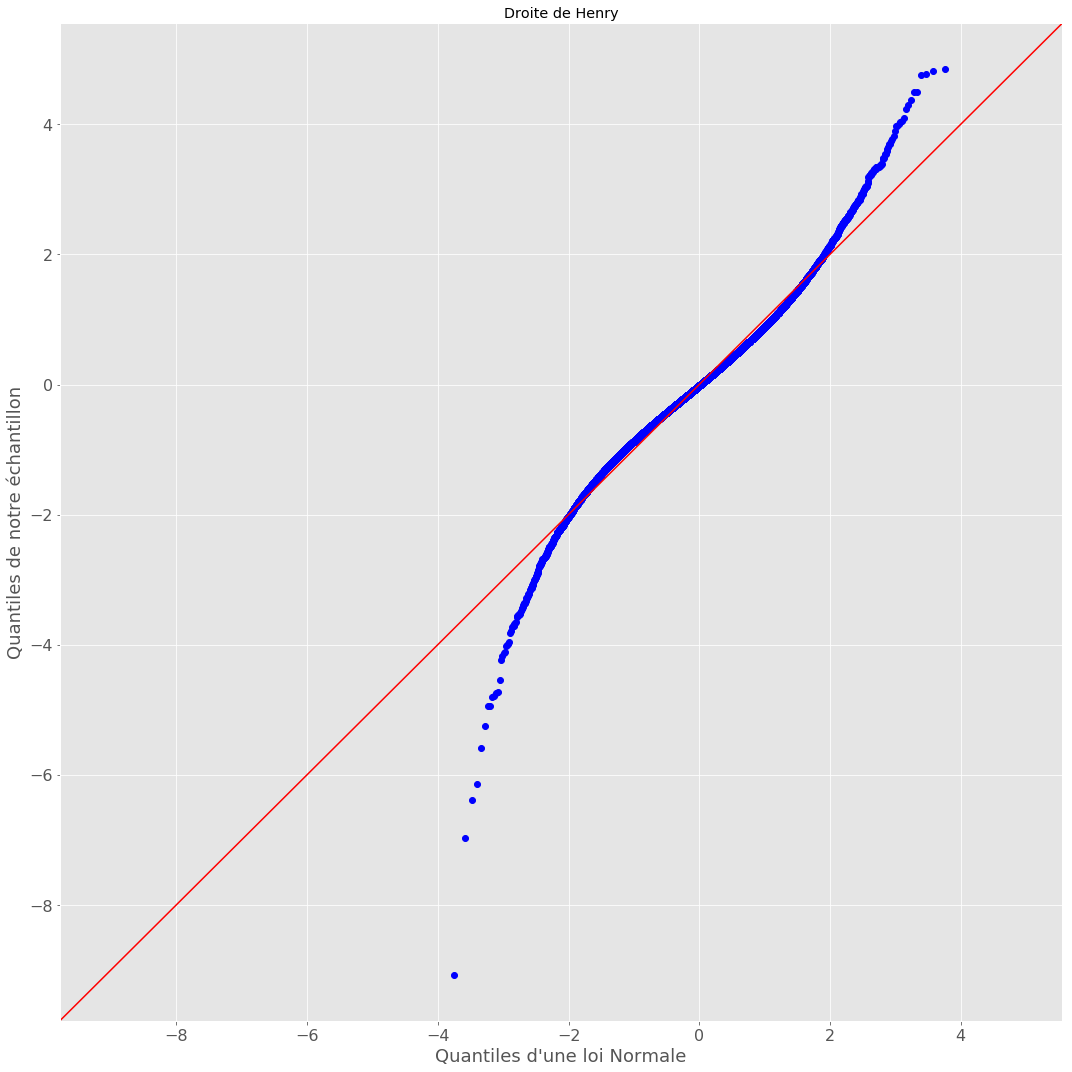

In [68]:
# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(reg_multi_ln.resid, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale', fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry')

plt.tight_layout()

plt.savefig('graph/droite_henry_reg1.png')
plt.show()

La droite de Henry represente la distribution empirique des residus et la distribution théorique d'une loi normale.  
Sauf pour les valeurs faibles de nos résidus, nos residus semblent plutôt alignés avec la distribution théorique d'une loi normale.

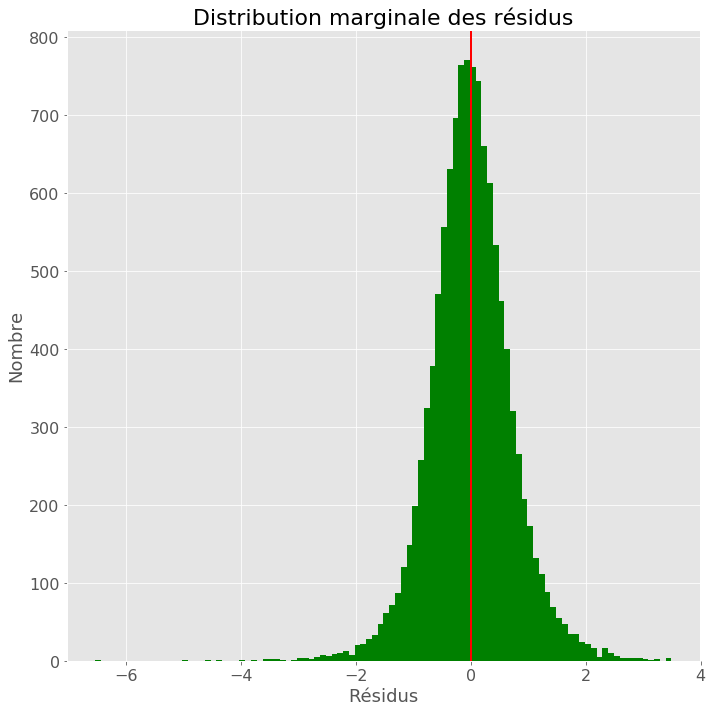

In [69]:
#Représentation de la distribution marginale
plt.figure(figsize=(10,10,))

plt.hist(X_ln, 100, facecolor='g',)
plt.axvline(Xbar_ln, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

plt.savefig('graph/dist_marg_resid_reg1.png')
plt.show()

<a id='reg2'></a>
## Régression linéaire du revenu enfant sur le revenu moyen du pays, l'indice de Gini et la classe de revenus des parents

<a id='test2'></a>
<h3 style='color:#8677b2'>Tests de significativité</h3>

[Haut de page](#sommaire)

In [70]:
reg2 = smf.ols('y_child ~ Gj + mj + c_i_parent', data=ready_db1)
reg_multi2 = reg2.fit()
reg_multi2.summary().tables[0]

Dep. Variable:,y_child,R-squared:,0.522
Model:,OLS,Adj. R-squared:,0.522
Method:,Least Squares,F-statistic:,2.113e+06
Date:,"Wed, 22 May 2019",Prob (F-statistic):,0.00
Time:,14:51:31,Log-Likelihood:,-5.9157e+07
No. Observations:,5800000,AIC:,1.183e+08
Df Residuals:,5799996,BIC:,1.183e+08
Df Model:,3,,
Covariance Type:,nonrobust,,


**Test global:**  
H0: beta_GJ = beta_mj = beta_c_i_parent = 0  
H1: beta_GJ != beta_mj = beta_c_i_parent != 0  
F ~ 0.00 <<< alpha, on rejette H0, le modèle est globalement significatif

In [71]:
reg_multi2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2646.7922,15.078,-175.540,0.000,-2676.345,-2617.240
Gj,0.5893,32.659,0.018,0.986,-63.420,64.599
mj,1.0000,0.000,2294.441,0.000,0.999,1.001
c_i_parent,52.4077,0.094,559.690,0.000,52.224,52.591


 **Test de significativité:**
   
H0: beta_Gj = 0  
H1: beta_Gj != 0  
Le paramètre beta_Gj de la variable Gj (indice de gini) n'est pas significatif au niveau de test alpha (0.05)  
En effet p-value ~ 1 > alpha, on accepte H0, le paramètre n'est pas significatif (beta_Gj = 0)  
  
H0: beta_mj = 0  
H1: beta_mj != 0  
Le paramètre beta_mj de la variable mj est significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_mj != 0)  
  
H0: beta_c_i_parent = 0  
H1: beta_c_i_parent != 0  
Le paramètre beta_c_i_parent de la variable c_i_parent est significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_c_i_parent != 0) 

<a id='log2'></a>
<h3 style='color:#8677b2'>Passage au logarithme du revenu enfant</h3>

[Haut de page](#sommaire)

In [72]:
reg_ln2 = smf.ols('ln_y_child ~ Gj + ln_mj + c_i_parent', data=ready_db1)
reg_multi_ln2 = reg_ln2.fit()

reg_multi_ln2.summary().tables[0]

Dep. Variable:,ln_y_child,R-squared:,0.785
Model:,OLS,Adj. R-squared:,0.785
Method:,Least Squares,F-statistic:,7.060e+06
Date:,"Wed, 22 May 2019",Prob (F-statistic):,0.00
Time:,14:51:33,Log-Likelihood:,-5.6444e+06
No. Observations:,5800000,AIC:,1.129e+07
Df Residuals:,5799996,BIC:,1.129e+07
Df Model:,3,,
Covariance Type:,nonrobust,,


**Test global:**  
H0: beta_GJ = beta_ln_mj = beta_c_i_parent = 0  
H1: beta_GJ != beta_ln_mj = beta_c_i_parent != 0  
F ~ 0.00 <<< alpha, on rejette H0, le modèle est globalement significatif

In [73]:
reg_multi_ln2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0773,0.003,-29.436,0.000,-0.082,-0.072
Gj,-1.6521,0.003,-529.950,0.000,-1.658,-1.646
ln_mj,0.9864,0.000,4100.914,0.000,0.986,0.987
c_i_parent,0.0113,9.21e-06,1231.637,0.000,0.011,0.011


**Test de significativité:**
   
H0: beta_Gj = 0  
H1: beta_Gj != 0  
Le paramètre beta_Gj de la variable Gj (indice de gini) n'est pas significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0<<< alpha, on rejette H0, le paramètre est significatif (beta_Gj = 0)  
  
H0: beta_ln_mj = 0  
H1: beta_ln_mj != 0  
Le paramètre beta_ln_mj de la variable ln_mj est significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_ln_mj != 0)  
  
H0: beta_c_i_parent = 0  
H1: beta_c_i_parent != 0  
Le paramètre beta_c_i_parent de la variable c_i_parent est significatif au niveau de test alpha (0.05)  
En effet p-value ~ 0.00 <<< alpha, on rejette H0, le paramètre est significatif (beta_c_i_parent != 0)  

<a id='rsq2'></a>
<h3 style='color:#8677b2'>Analyses de $R^2$</h3>

[Haut de page](#sommaire)

In [74]:
# Anova sur notre régression linéaire
anova2 = sm.stats.anova_lm(reg_multi_ln2, typ=1)
anova2

,df,sum_sq,mean_sq,F,PR(>F)
Gj,1.0,1.167249e+06,1.167249e+06,2.846797e+06,0.0
ln_mj,1.0,6.895167e+06,6.895167e+06,1.681658e+07,0.0
c_i_parent,1.0,6.219749e+05,6.219749e+05,1.516931e+06,0.0
Residual,5799996.0,2.378126e+06,4.100219e-01,NaN,NaN


In [75]:
# Calcul du R2 pour la variable 'c_i_parent'
r2_c_i_parent = anova2.iloc[2,1] / anova2['sum_sq'].sum()
r2_c_i_parent

0.056223631320390044

In [76]:
# Vérification
r2_Gj + r2_ln_mj + r2_c_i_parent, reg_multi_ln2.rsquared

(0.7850285283326355, 0.7850285283331276)

In [77]:
print(f'Dans notre modèle:\n\n\
La variable \'Gj\' explique {100 * r2_Gj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
La variable \'ln_y_child_moy\' explique {100 * r2_ln_mj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
La variable \'c_i_parent\' explique {100 * r2_c_i_parent:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
Notre modèle explique {100 * reg_multi_ln2.rsquared:.2f}% de la variance de la variable \'ln_y_child\'')

Dans notre modèle:

La variable 'Gj' explique 10.55% de la variance de la variable 'ln_y_child'

La variable 'ln_y_child_moy' explique 62.33% de la variance de la variable 'ln_y_child'

La variable 'c_i_parent' explique 5.62% de la variance de la variable 'ln_y_child'

Notre modèle explique 78.50% de la variance de la variable 'ln_y_child'


<a id='vif2'></a>
<h3 style='color:#8677b2'>Détection des problèmes de colinéarité</h3>

[Haut de page](#sommaire)

In [78]:
# Facteur d'influence de la variance (Variance Inflation Factor)
variables_ln2 = reg_multi_ln2.model.exog
[variance_inflation_factor(variables_ln2, i) for i in np.arange(1,variables_ln2.shape[1])]

[1.0769055302378576, 1.0769055362086744, 1.0000000090297747]

 * VIF_Gj et VIF_ln_y_child_moy < 10 (ou 5)  
Pas de problème de colinéarité

<a id='breu2'></a>
<h3 style='color:#8677b2'>Test d'homoscédasticité</h3>

[Haut de page](#sommaire)

In [79]:
_, pval2, __, f_pval2 = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_ln2.resid, variables_ln2)
print('p value test Breusch Pagan:', pval2)

p value test Breusch Pagan: 0.0


H0: Homoscédasticité  
H1: Hétéroscédasticité  
pvalue <<< alpha, rejet de H0, il y a hétéroscédasticité des residus  
Toutefois, le modèle de regression linéaire multiple est robuste pour les grands échantillon. 5_800_000 ici, c'est notre cas.  
Plus on a de données à disposition, plus le modèle est capable de supporter des écarts important aux hypothèse (gaussienne et homoscédastique)

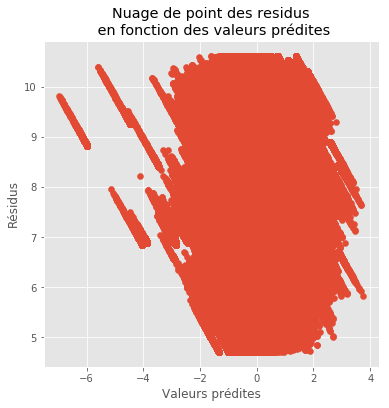

In [80]:
# Représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_ln2.resid, reg_multi_ln2.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

plt.savefig('graph/homoscedasticity2.png')
plt.show()

<a id='norm2'></a>
<h3 style='color:#8677b2'>Test de normalité des résidus</h3>

[Haut de page](#sommaire)

In [81]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
X_ln2 = reg_multi_ln2.resid
Xbar_ln2 = np.mean(X_ln2)
Xsprime_ln2 = np.std(X_ln2)

ks_2samp(reg_multi_ln2.resid, list(np.random.normal(Xbar_ln2, Xsprime_ln2, 5_800_000)))

Ks_2sampResult(statistic=0.02693482758620691, pvalue=0.0)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
p-value <<< 0.05, on rejette H0, y_child ne suit pas une loi normale

In [82]:
# Test de Jarque-Bera (test de normalité basé sur le kurtosis et le skewness)
JB_ln1, JBpv_ln1, skw_ln1, kurt_ln1 = sm.stats.stattools.jarque_bera(reg_multi_ln2.resid)
JB_ln1, JBpv_ln1, skw_ln1, kurt_ln1

(1809740.6573621256, 0.0, -0.1310428968088434, 5.723948066180366)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
JBpv ~ 0, on rejette H0, d'après le test, les données ne suivent pas une loi normale

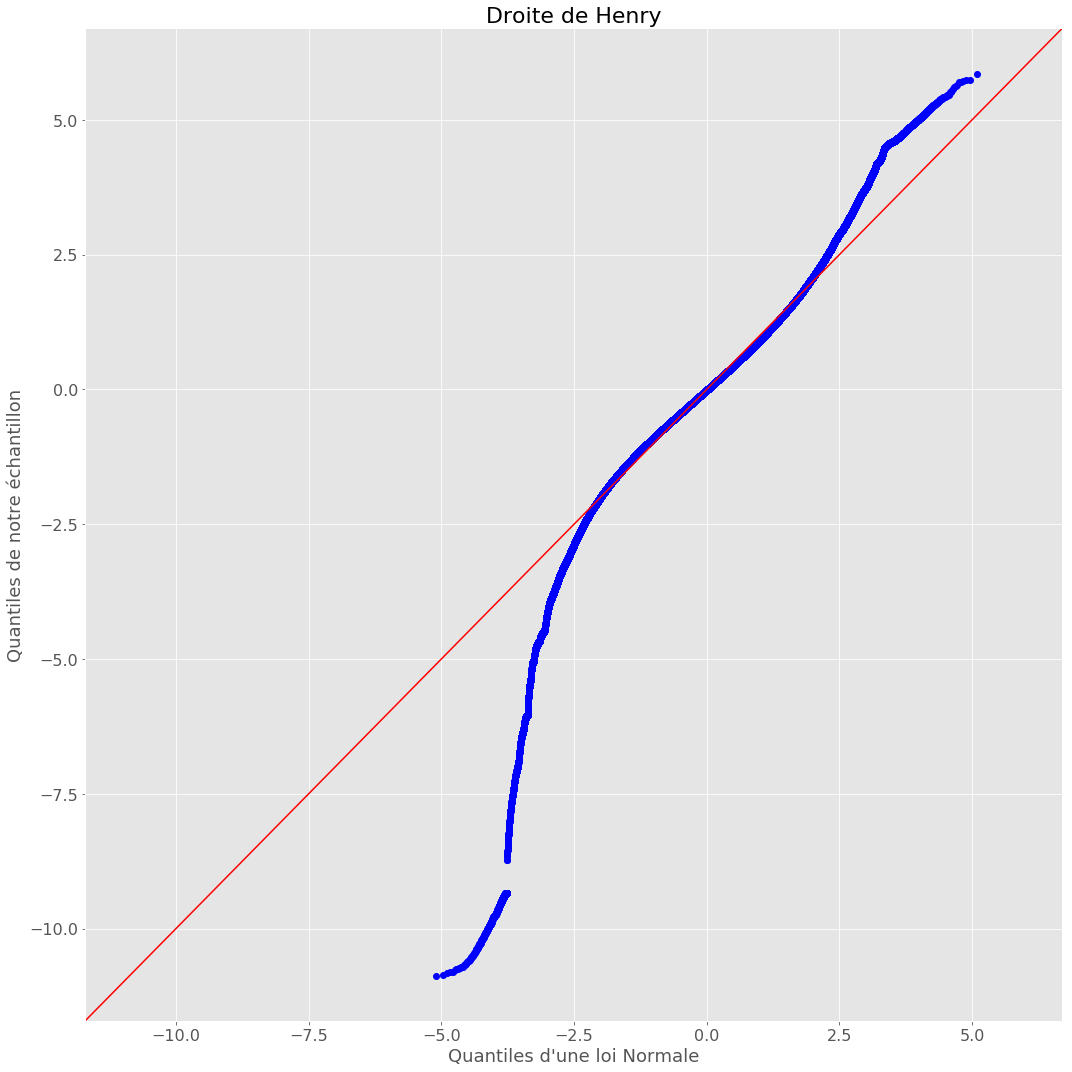

In [83]:
# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X_ln2, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry',fontsize=22)

plt.tight_layout()

plt.savefig('graph/droite_henry_reg2.png')
plt.show()

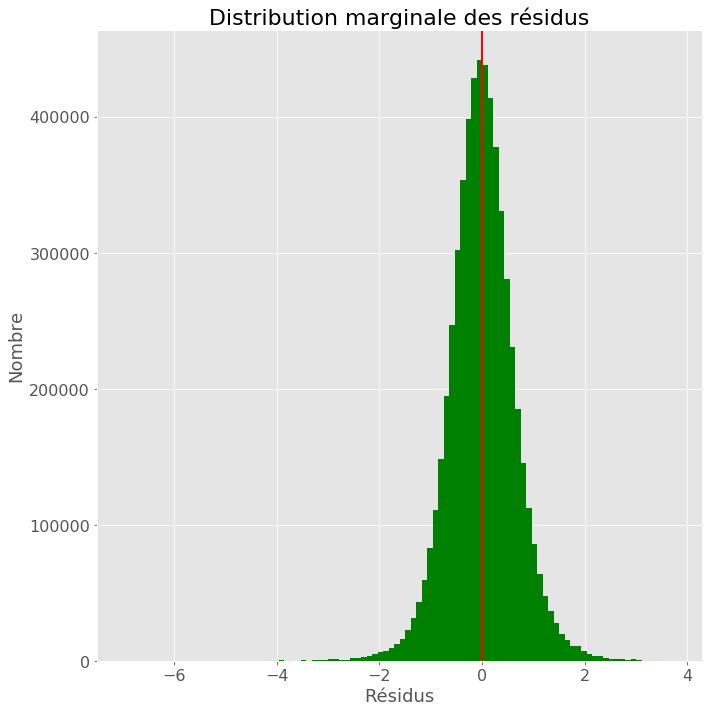

In [84]:
#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X_ln2, 100, facecolor='g')
plt.axvline(Xbar_ln2, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

plt.savefig('graph/dist_marg_resid_reg2.png')
plt.show()

<a id='ccl'></a>
## Conclusion

[Haut de page](#sommaire)

In [85]:
aic = [anova_pays.aic, reg_multi_ln.aic, reg_multi_ln2.aic, ]
bic = [anova_pays.bic, reg_multi_ln.bic, reg_multi_ln2.bic, ]
R2 = [100 * anova_pays.rsquared, 100 * reg_multi_ln.rsquared, 100 * reg_multi_ln2.rsquared, ]
model_ccl = pd.DataFrame({'AIC': aic,
                          'BIC': bic,
                          'R2': R2},
                        index= ['ANOVA', 'Reg_mj_Gj', 'Reg_mj_Gj_Cip'])

model_ccl = model_ccl[['AIC', 'BIC', 'R2']].round(1)

model_ccl

,AIC,BIC,R2
ANOVA,237471.7,238325.3,49.6
Reg_mj_Gj,25278.5,25300.6,72.9
Reg_mj_Gj_Cip,11288732.1,11288786.4,78.5


[Haut de page](#sommaire)

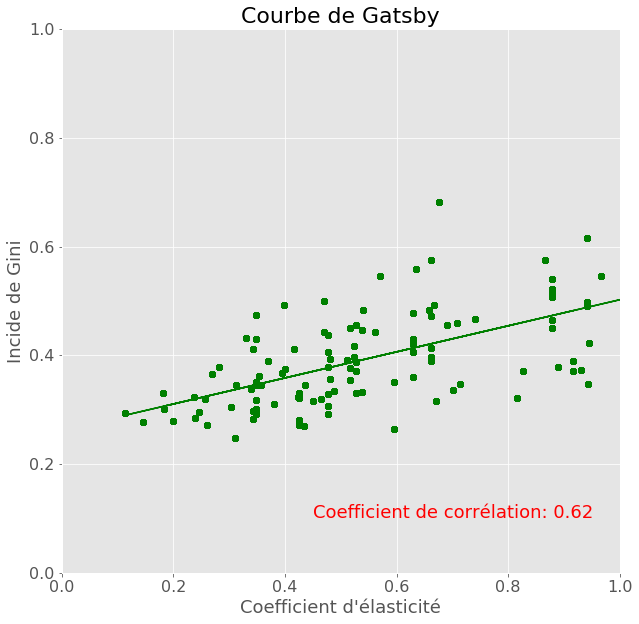

In [86]:
# Préparation des données
y = ready_db2.Gj
x = ready_db2.pj

# Calcul du coefficient de corrélation
pear = scipy.stats.pearsonr(x,y)[0]

# Cacul des paramètres
slope, intercept, _, __, ___ = scipy.stats.linregress(x, y)

# Droite de régression
fitLine = slope * x + intercept

# Courbe de Gatsby
plt.figure(figsize=(10,10))
plt.plot(x, fitLine, c='g')
plt.scatter(x, y, c='g')
plt.text(0.45, 0.1, f'Coefficient de corrélation: {pear:.2}', color='r', fontsize=18)

# Décoration
plt.title('Courbe de Gatsby', fontsize=22)
plt.ylabel('Incide de Gini', fontsize=18)
plt.ylim(0, 1)
plt.yticks(fontsize=16)
plt.xlabel('Coefficient d\'élasticité', fontsize=18)
plt.xticks(fontsize=16)
plt.xlim(0, 1)



plt.savefig('graph/courbe_gatsby.png')
plt.show()